In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import time
from typing import List, Union
from tqdm import tqdm
from datetime import datetime
import yfinance as yf

/Users/christopherli/ML/Trading/LSTM/venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31", auto_adjust=False)
data.index = pd.to_datetime(data.index)

[*********************100%***********************]  1 of 1 completed


In [3]:
lookback = 24
horizon = 1

close = data["Close"]
returns = np.log(close).diff().dropna().values.reshape(-1, 1)


In [4]:
training_len = int(np.ceil(len(returns) * 0.90))
train_returns = returns[:training_len]
test_returns = returns[training_len - lookback:]

scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_returns)
scaled_test = scaler.transform(test_returns)

In [5]:
X_train, y_train = [], []
for i in range(lookback, len(scaled_train) - horizon + 1):
    X_train.append(scaled_train[i - lookback:i, 0])
    y_train.append(scaled_train[i + horizon - 1, 0])

X_train = np.array(X_train).reshape(-1, lookback, 1)
y_train = np.array(y_train)

In [6]:
X_test, y_test = [], []
for i in range(lookback, len(scaled_test) - horizon + 1):
    X_test.append(scaled_test[i - lookback:i, 0])
    y_test.append(scaled_test[i + horizon - 1, 0])

X_test = np.array(X_test).reshape(-1, lookback, 1)
y_test = np.array(y_test)

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))

/Users/christopherli/ML/Trading/LSTM/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.summary()
model.compile(optimizer="adam", loss="mae", metrics=[keras.metrics.RootMeanSquaredError(), "r2_score"])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
training = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7098 - r2_score: -0.0037 - root_mean_squared_error: 1.0050
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7082 - r2_score: -0.0035 - root_mean_squared_error: 1.0049
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7099 - r2_score: -0.0036 - root_mean_squared_error: 1.0049 
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7090 - r2_score: -0.0023 - root_mean_squared_error: 1.0043
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7077 - r2_score: 0.0020 - root_mean_squared_error: 1.0022
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7068 - r2_score: 0.0023 - root_mean_squared_error: 1.0020    
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7076 - r2_score: 0.0014 - root_mean_squared_error: 1.0025 
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7068 - r2_score: 0.0040 - root_mean_squared_error: 1.0011
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s

In [10]:
predictions = model.predict(X_test)
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [11]:
train = data[:training_len].copy()
test = data[training_len:].copy()

predictions_flat = predictions_actual.flatten()

# 2️⃣ Reconstruct predicted prices from last training price
last_train_price = float(train["Close"].iloc[-1])
pred_cum_returns = np.cumsum(predictions_flat)
pred_prices = last_train_price * np.exp(pred_cum_returns)

# 3️⃣ Align test dataframe exactly to predictions
num_test_seq = X_test.shape[0]
test_aligned = test.iloc[:num_test_seq].copy().reset_index(drop=True)  # reset index to avoid misalignment
test_aligned["Predictions"] = pred_prices




/var/folders/2b/zvv8556n7vbfkz5g_xhjv4mc0000gn/T/ipykernel_38851/434097207.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_train_price = float(train["Close"].iloc[-1])


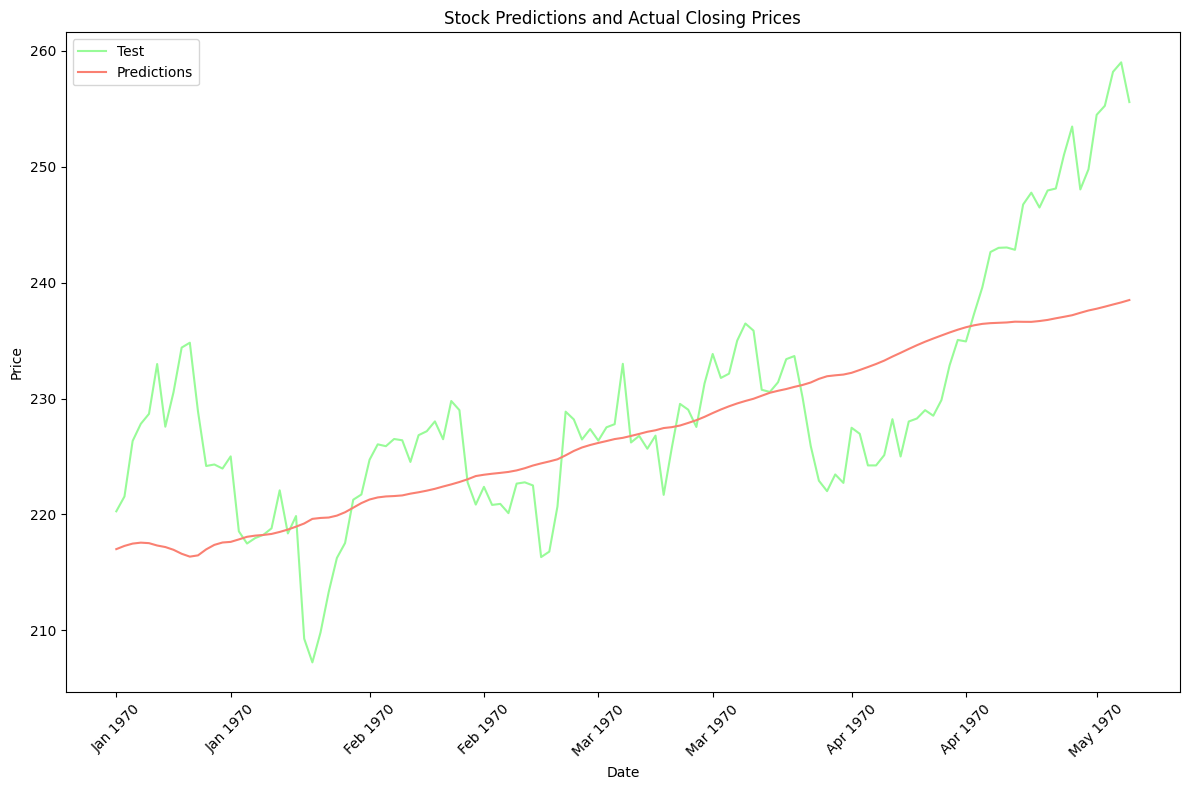

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot actual vs predicted prices
ax.plot(test_aligned.index, test_aligned["Close"], color="palegreen", label="Test")
ax.plot(test_aligned.index, test_aligned["Predictions"], color="salmon", label="Predictions")

# Format the x-axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title("Stock Predictions and Actual Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

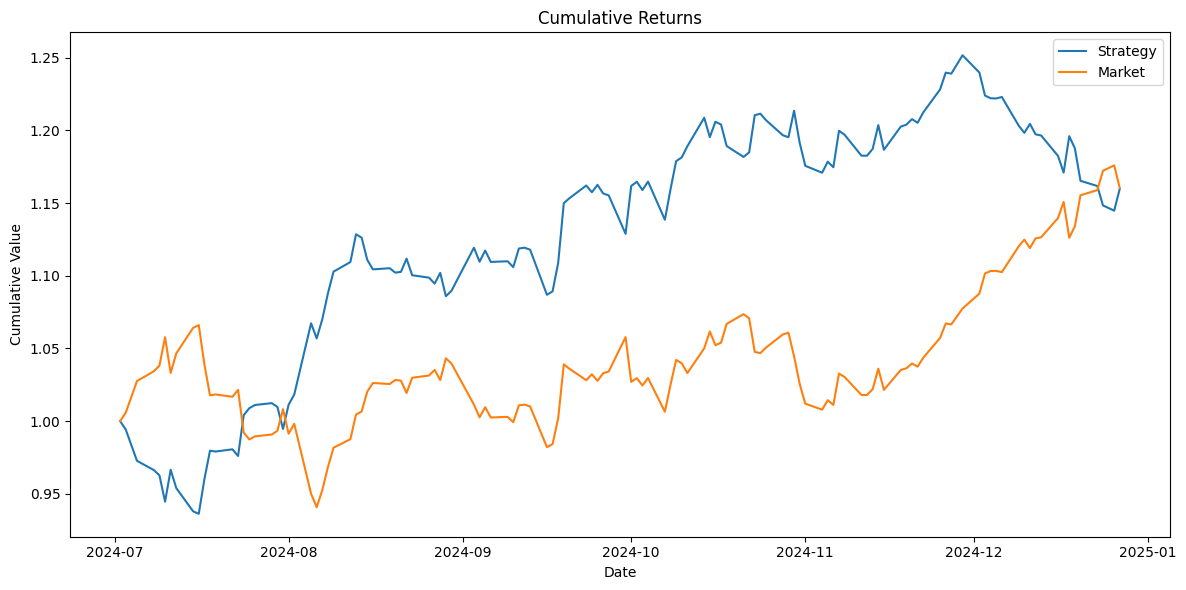

Profit Factor: 1.3082309206503948
Cumulative Return: 0.15989783991016893
Sharpe Ratio: 1.5834349980483207
Max Drawdown: 0.08542428023537668


In [16]:
pred_prices_flat = pred_prices.flatten()

num_test_seq = len(pred_prices_flat)
test_aligned = test.iloc[:num_test_seq].copy()
test_aligned = test_aligned.copy()

test_aligned["Predictions"] = pred_prices_flat

close_series = test_aligned["Close"].squeeze()

test_aligned["Signal"] = np.where(pred_prices_flat > close_series, 1, -1)

test_aligned["Return"] = close_series.pct_change()
test_aligned["Strategy_Return"] = test_aligned["Signal"].shift(1) * test_aligned["Return"]

gross_profit = test_aligned.loc[test_aligned["Strategy_Return"] > 0, "Strategy_Return"].sum()
gross_loss = -test_aligned.loc[test_aligned["Strategy_Return"] < 0, "Strategy_Return"].sum()
profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan

test_aligned["Cumulative_Strategy"] = (1 + test_aligned["Strategy_Return"].fillna(0)).cumprod()
test_aligned["Cumulative_Market"] = (1 + test_aligned["Return"].fillna(0)).cumprod()
cumulative_return = test_aligned["Cumulative_Strategy"].iloc[-1] - 1

periods_per_year = 252
mean_return = test_aligned["Strategy_Return"].mean()
std_return = test_aligned["Strategy_Return"].std()
sharpe_ratio = (mean_return / std_return) * np.sqrt(periods_per_year) if std_return != 0 else np.nan

equity = test_aligned["Cumulative_Strategy"]
running_max = equity.cummax()
drawdown = (running_max - equity) / running_max
max_drawdown = drawdown.max()

plt.figure(figsize=(12, 6))
plt.plot(test_aligned.index, test_aligned["Cumulative_Strategy"], label="Strategy")
plt.plot(test_aligned.index, test_aligned["Cumulative_Market"], label="Market")
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.tight_layout()
plt.show()

print("Profit Factor:", profit_factor)
print("Cumulative Return:", cumulative_return)
print("Sharpe Ratio:", sharpe_ratio)
print("Max Drawdown:", max_drawdown)


In [17]:

def train_LSTM(model, X, y, epochs=10, batch_size=32):
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

def get_factors(test_aligned):
    close_series = test_aligned["Close"].squeeze()
    
    test_aligned["Signal"] = np.where(test_aligned["Predictions"] > close_series, 1, -1)
    
    test_aligned["Return"] = close_series.pct_change()
    test_aligned["Strategy_Return"] = test_aligned["Signal"].shift(1) * test_aligned["Return"]
    
    gross_profit = test_aligned.loc[test_aligned["Strategy_Return"] > 0, "Strategy_Return"].sum()
    gross_loss = -test_aligned.loc[test_aligned["Strategy_Return"] < 0, "Strategy_Return"].sum()
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
    
    test_aligned["Cumulative_Strategy"] = (1 + test_aligned["Strategy_Return"].fillna(0)).cumprod()
    test_aligned["Cumulative_Market"] = (1 + test_aligned["Return"].fillna(0)).cumprod()
    cumulative_return = test_aligned["Cumulative_Strategy"].iloc[-1] - 1
    
    periods_per_year = 252
    mean_return = test_aligned["Strategy_Return"].mean()
    std_return = test_aligned["Strategy_Return"].std()
    sharpe_ratio = (mean_return / std_return) * np.sqrt(periods_per_year) if std_return != 0 else np.nan
    
    equity = test_aligned["Cumulative_Strategy"]
    running_max = equity.cummax()
    drawdown = (running_max - equity) / running_max
    max_drawdown = drawdown.max()
    
    return {
        "Profit factor": profit_factor,
        "Cumulative return": cumulative_return,
        "Sharpe ratio": sharpe_ratio,
        "Max drawdown": max_drawdown
    }

def optimize_LSTM(periods: list, model, data):
    stock_close = data[["Close"]].copy()
    dataset = stock_close.values.reshape(-1, 1)
    training_len = int(np.ceil(len(dataset) * 0.90))
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataset)
    
    results = []
    trained_models = []
    all_predictions = []
    
    for period in periods:
        model_copy = keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights())
        model_copy.compile(optimizer="adam", loss="mae")
        
        X_train, y_train = [], []
        for i in range(period, training_len):
            X_train.append(scaled_data[i-period:i, 0])
            y_train.append(scaled_data[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        
        train_LSTM(model_copy, X_train, y_train, epochs=20)

        test_data = scaled_data[training_len - period:]
        X_test = []
        for i in range(period, len(test_data)):
            X_test.append(test_data[i-period:i, 0])
        X_test = np.array(X_test)
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        
        predictions = model_copy.predict(X_test)
        predictions_actual = scaler.inverse_transform(predictions)
        predictions_flat = predictions_actual.flatten()
        
        test_df = data[training_len:].copy()
        num_test_seq = len(predictions_flat)
        test_aligned = test_df.iloc[:num_test_seq].copy()
        test_aligned["Predictions"] = predictions_flat
        
        factors = get_factors(test_aligned)
        
        results.append((period, factors))
        trained_models.append(model_copy)
        all_predictions.append(predictions_flat)
        
        print(f"Lookback period: {period}")
        for key, value in factors.items():
            print(f"{key}: {value}")
        print("-" * 40)
    
    results_df = pd.DataFrame([
        {"Lookback": period, **factors} for period, factors in results
    ])
    
    return results_df, trained_models, all_predictions


In [18]:
results_df, models, predictions = optimize_LSTM([1, 6, 12, 24, 36, 48, 72], model, data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Lookback period: 1
Profit factor: 0.8289259919285913
Cumulative return: -0.114777088686155
Sharpe ratio: -1.1094326510715293
Max drawdown: 0.17429353197327047
----------------------------------------
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x16e024b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 

In [19]:
best_row = results_df.loc[results_df["Profit factor"].idxmax()]

best_lookback = best_row["Lookback"]
best_pf = best_row["Profit factor"]
best_model = models[results_df.index.get_loc(best_row.name)]
best_prediction = predictions[results_df.index.get_loc(best_row.name)]

In [20]:

def get_permutation(
    ohlc: Union[pd.DataFrame, List[pd.DataFrame]], 
    start_index: int = 0, 
    seed: int = None
):

    assert start_index >= 0, "start_index must be >= 0"

    np.random.seed(seed)

    # Ensure list format
    if isinstance(ohlc, list):
        time_index = ohlc[0].index
        for mkt in ohlc:
            assert np.all(time_index == mkt.index), "Indexes do not match across markets"
        n_markets = len(ohlc)
    else:
        ohlc = [ohlc]
        n_markets = 1
        time_index = ohlc[0].index

    n_bars = len(ohlc[0])
    perm_index = start_index + 1
    perm_n = n_bars - perm_index

    start_bar = np.empty((n_markets, 4))
    relative_open = np.empty((n_markets, perm_n))
    relative_high = np.empty((n_markets, perm_n))
    relative_low = np.empty((n_markets, perm_n))
    relative_close = np.empty((n_markets, perm_n))

    for mkt_i, df in enumerate(ohlc):
        log_bars = np.log(df[['open', 'high', 'low', 'close']])

        start_bar[mkt_i] = log_bars.iloc[start_index].to_numpy()

        r_o = (log_bars['open'] - log_bars['close'].shift()).to_numpy()
        r_h = (log_bars['high'] - log_bars['open']).to_numpy()
        r_l = (log_bars['low'] - log_bars['open']).to_numpy()
        r_c = (log_bars['close'] - log_bars['open']).to_numpy()

        relative_open[mkt_i] = r_o[perm_index:]
        relative_high[mkt_i] = r_h[perm_index:]
        relative_low[mkt_i] = r_l[perm_index:]
        relative_close[mkt_i] = r_c[perm_index:]

    idx = np.arange(perm_n)

    relative_high = relative_high[:, np.random.permutation(idx)]
    relative_low  = relative_low[:, np.random.permutation(idx)]
    relative_close = relative_close[:, np.random.permutation(idx)]

    relative_open = relative_open[:, np.random.permutation(idx)]

    perm_ohlc = []
    for mkt_i, df in enumerate(ohlc):
        perm_bars = np.zeros((n_bars, 4))
        log_bars = np.log(df[['open', 'high', 'low', 'close']]).to_numpy().copy()

        perm_bars[:start_index] = log_bars[:start_index]
        perm_bars[start_index] = start_bar[mkt_i]

        for i in range(perm_index, n_bars):
            k = i - perm_index
            perm_bars[i, 0] = perm_bars[i-1, 3] + relative_open[mkt_i, k]
            perm_bars[i, 1] = perm_bars[i, 0] + relative_high[mkt_i, k]
            perm_bars[i, 2] = perm_bars[i, 0] + relative_low[mkt_i, k]
            perm_bars[i, 3] = perm_bars[i, 0] + relative_close[mkt_i, k]

        perm_bars = np.exp(perm_bars)
        perm_ohlc.append(pd.DataFrame(perm_bars, index=time_index, columns=['open', 'high', 'low', 'close']))

    return perm_ohlc if n_markets > 1 else perm_ohlc[0]


In [22]:
def permutation_test_pf(
    data: pd.DataFrame, 
    best_prediction: np.ndarray, 
    training_len: int, 
    n_permutations: int = 1000
):
    """
    Perform a Monte Carlo permutation test on the Profit Factor metric
    for shuffled LSTM predictions.
    """
    best_prediction_flat = best_prediction.flatten()
    
    num_pred = len(best_prediction_flat)
    test_best = data.iloc[training_len: training_len + num_pred].copy()
    
    test_best["Predictions"] = best_prediction_flat
    
    real_pf = get_factors(test_best)["Profit factor"]
    print("Real Profit Factor:", real_pf)
    
    permuted_pfs = []
    all_shuffled_preds = []
    perm_better_count = 1
    
    for _ in range(n_permutations):
        shuffled_preds = np.random.permutation(best_prediction_flat)
        all_shuffled_preds.append(shuffled_preds)
        
        test_shuffled = test_best.copy()
        test_shuffled["Predictions"] = shuffled_preds
        
        pf = get_factors(test_shuffled)["Profit factor"]
        permuted_pfs.append(pf)
        
        if pf >= real_pf:
            perm_better_count += 1
            
    p_value = perm_better_count / n_permutations
    print(f"Permutation Test P-Value: {p_value}")
    
    plt.figure(figsize=(10, 5))
    pd.Series(permuted_pfs).hist(bins=100, alpha=0.7, label='Permutations')
    plt.axvline(real_pf, color='red', linewidth=2, label='Real PF')
    plt.xlabel("Profit Factor")
    plt.ylabel("Frequency")
    plt.title(f"In-sample Monte Carlo Permutation Test\nP-Value: {p_value:.4f}")
    plt.grid(False)
    plt.legend()
    plt.show()
    
    return p_value, permuted_pfs, all_shuffled_preds


Real Profit Factor: 1.2115667019255087
Permutation Test P-Value: 0.507


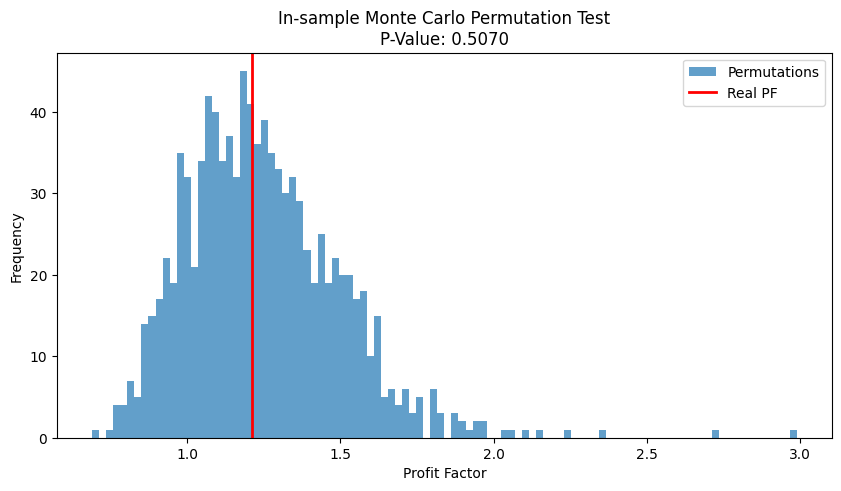

In [23]:
p_value, permuted_pfs, all_shuffled_preds = permutation_test_pf(
    data=data,
    best_prediction=best_prediction,
    training_len=training_len,
    n_permutations=1000
)